# Exemplo Classificação CNN

***
Classificação de imagens utilizando Redes Convulacionais
***
###### Author: Isabela Piccinini
###### Version: 0.1
###### Status: {tutorial_sample}
###### Las Update: May/2020
***

# IMPORTAÇÃO PACOTES

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

C:\apps\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\apps\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\apps\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\apps\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a fut

# PARTE 1: PREPARAÇÃO DADOS

Fonte: https://www.kaggle.com/debanga/facial-expression-recognition-challenge <br>

Dataset com expressões faciais, contendo as seguintes labels: <br>
_0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral_

### Importando a base e verificando conteúdo:

In [2]:
path = 'C:/Users/Isabela Piccinini/Downloads/facial-expression-recognition-challenge/'
file_input = 'icml_face_data.csv'

In [3]:
df_in = pd.read_csv(path + file_input)
print(df_in.shape)
df_in.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### Renomear colunas

In [4]:
# De para labels e emoções
emotions_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

df_in = df_in.rename(columns={'emotion':'label',' pixels':'image', ' Usage': 'Usage'})
df_in['emotion'] = df_in['label'].apply(lambda x: emotions_dict[int(x)])
df_in.head()

,label,Usage,image,emotion
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,Angry
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral


A coluna image está em formato string, então temos que fazer um parser para transformar em um array com a informação da imagem de 48 x 48 pixels (resolução imagem original).

In [5]:
# Criação de array images com a informação da escala de cinza da imagem
images = []
for id in df_in.index:
    images.append(np.reshape(np.array(df_in.image[id].split(' ')).astype(int),(48,48)))

images = np.array(images)

images[:2]

array([[[ 70,  80,  82, ...,  52,  43,  41],
        [ 65,  61,  58, ...,  56,  52,  44],
        [ 50,  43,  54, ...,  49,  56,  47],
        ...,
        [ 91,  65,  42, ...,  72,  56,  43],
        [ 77,  82,  79, ..., 105,  70,  46],
        [ 77,  72,  84, ..., 106, 109,  82]],

       [[151, 150, 147, ..., 129, 140, 120],
        [151, 149, 149, ..., 122, 141, 137],
        [151, 151, 156, ..., 109, 123, 146],
        ...,
        [188, 188, 121, ..., 185, 185, 186],
        [188, 187, 196, ..., 186, 182, 187],
        [186, 184, 185, ..., 193, 183, 184]]])

### Análise exploratória da base - Verificação se as labels fazem sentido

Para verificarmos o dataset, iremos plotar um exemplo de imagem de cada label que usaremos para treinamento do modelo.

Angry


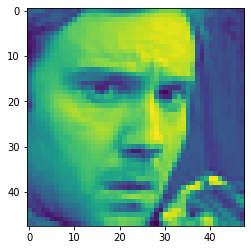

Disgust


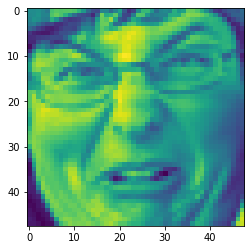

Fear


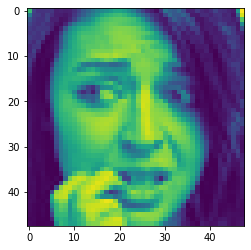

Happy


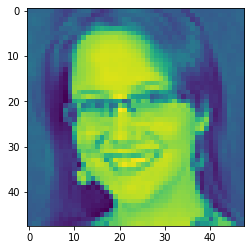

Sad


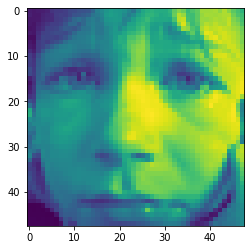

Surprise


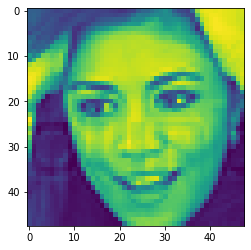

Neutral


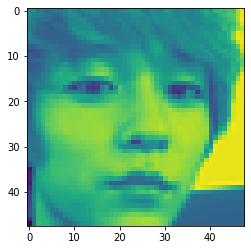

In [130]:
# Plot one example of each class
for id in [0 , 299, 21, 7, 6, 39, 13]:
    plt.imshow(images[id])
    print(df_in.emotion[id])
    plt.show()

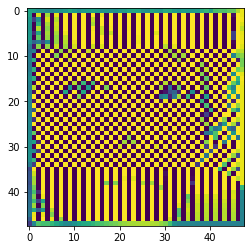

In [24]:
# Aplicando filtro de arestas para entendimento
filter = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
weight  = 1

size_x = images[id].shape[0]
size_y = images[id].shape[1]
i = images[id].copy()

for x in range(1,size_x-1):
    for y in range(1,size_y-1):
        convolution = 0.0
        convolution = convolution + (i[x - 1, y-1] * filter[0][0])
        convolution = convolution + (i[x, y-1] * filter[0][1])
        convolution = convolution + (i[x + 1, y-1] * filter[0][2])
        convolution = convolution + (i[x-1, y] * filter[1][0])
        convolution = convolution + (i[x, y] * filter[1][1])
        convolution = convolution + (i[x+1, y] * filter[1][2])
        convolution = convolution + (i[x-1, y+1] * filter[2][0])
        convolution = convolution + (i[x, y+1] * filter[2][1])
        convolution = convolution + (i[x+1, y+1] * filter[2][2])
        convolution = convolution * weight
        if(convolution<0):
            convolution=0
        if(convolution>255):
            convolution=255
        i[x, y] = convolution
                                     
plt.imshow(i)
plt.show()

### Análise exploratória da base - Verificação distribuição

Notamos que a base não está balanceada (mesmo número de amostras para cada uma das classes, o que seria o ideal). O desbalanceamento se dá principalmente com relação a duas classes: <br>
1. Apresenta predominância de registros da classe **_"Happy"_**, o que pode gerar um _bias_ ao modelo, tendendo a favorecer  essa classe majoritária. <br>
2. Do contrário, possui muitas poucas amostras para a classe **_"Disgust"_**. Isso pode gerar uma acurácia muito baixa para essa classe, dado que o modelo não irá ter insumo o suficiente para aprender o padrão para essa expressão facial. <br>

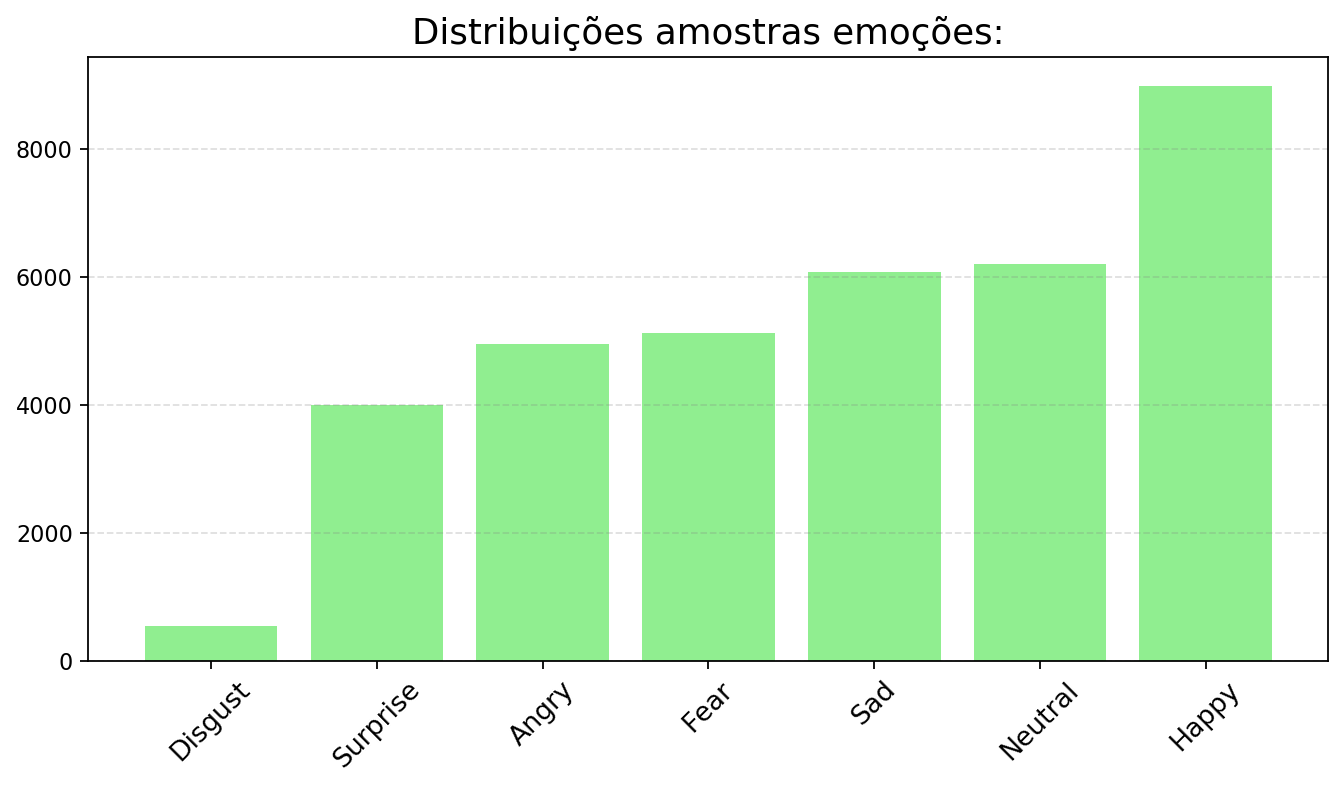

In [96]:
emotions = df_in.groupby('emotion').label.count().reset_index().sort_values('label')

fig, ax = plt.subplots(figsize=(10, 5), dpi=160)
ax.set_title('Distribuições amostras emoções:', fontsize=16)
plt.bar(emotions.loc[:, 'emotion'], emotions.loc[:, 'label'], color='lightgreen')
ax.yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
plt.xticks(rotation=45, fontsize=12)
plt.show()

# PARTE 2: Modelagem

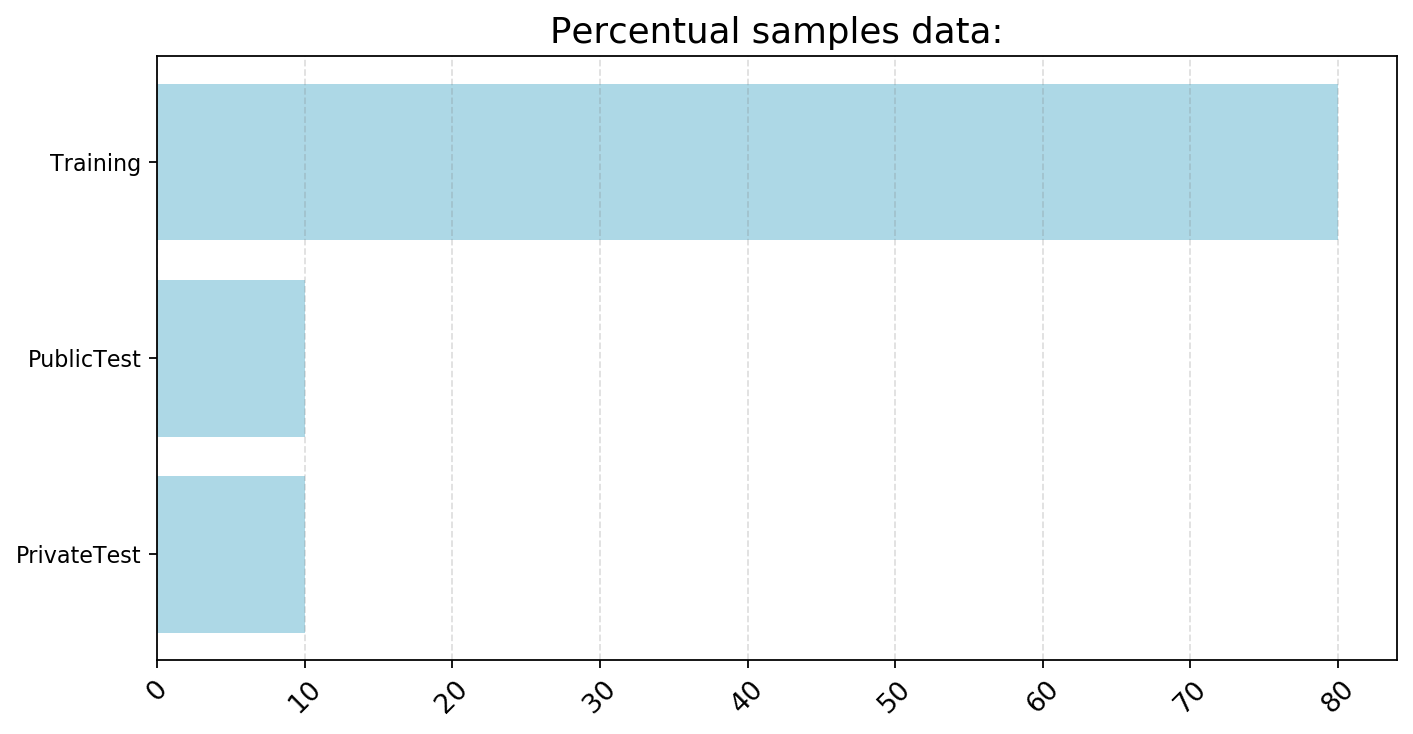

In [27]:
sample = df_in.groupby('Usage').label.count().reset_index().sort_values('label')
sample['label'] = (sample['label'] / len(df_in)) * 100

fig, ax = plt.subplots(figsize=(10, 5), dpi=160)
ax.set_title('Percentual samples data:', fontsize=16)
plt.barh(sample.loc[:, 'Usage'], sample.loc[:, 'label'], color='lightblue')
ax.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
plt.xticks(rotation=45, fontsize=12)
plt.show()

### Separar base de treino de teste

Iremos utilizar 80% para treino (Usage = Training) e 20% para teste (Usage = PublicTest or PrivateTest), conforme mostra o gráfico acima.

In [112]:
img_train  = np.array(images)[df_in['Usage']=='Training']
label_train = np.array(df_in.loc[df_in['Usage']=='Training', 'label'])
img_test = np.array(images)[df_in['Usage']!='Training']
label_test = np.array(df_in.loc[df_in['Usage']!='Training', 'label'])
print(df_in.shape, img_train.shape, img_test.shape)

(35887, 4) (28709, 48, 48) (7178, 48, 48)


### Normalizar dados entre 0 e 1

A escala de valores de tons de cinza varia entre 0 e 255. Para facilitar o processamento da rede neural realizaremos a normalização dos dados 0 e 1, dividindo os valores da matriz de dados pelo valor máximo presente, no caso 255. <br>

In [113]:
img_train = img_train / 255.0
img_test = img_test / 255.0

### Transformar para um tensor com apenas uma camada

Como entrada, uma CNN assume tensores de forma (altura da imagem, largura da imagem, canais de cores), ignorando o tamanho do lote. Uma vez que temos um único canal de cores e uma imagem de 48 x 48 pixels, temos que fazer uma transformação em um tensor de uma única camada (n amostras x 48 x 48 x 1).

In [114]:
img_train = img_train.reshape(-1, 48, 48, 1)
print(img_train.shape)
img_test = img_test.reshape(-1, 48, 48, 1)
print(img_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)


### Criar modelo no tensorflow

**Camadas da arquitetura rede inicial:** <br>

- [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): incluiremos duas camadas convulacionais com filtros de janela tamanho 3 x 3 (kernel), sendo que para a primeira camada usaremos metade do número de filtros (nós) que para a segunda (para tentar otimizar o processamento computacional). A imagem de entrada da primeira camda é um tensor 48 x 48 x 1 (input_shape). Em ambas camadas utilizaremos Relu como função de ativação (mantem os valores de sáida sempre positivos). <br>

- [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): após cada convolução, aplicamos incluímos uma camada de pooling para redução do número de dimensões da imagem pela metade, mantendo o valor máximo dentre os pixels dentro da janela escolhida de 2x2. Isso é realizado por motivos computacionais, para simplicação da estrutura de saída, mas ainda mantendo as principais características da imagem de entrada. Uma vez que o tamanho da imagem diminui da primeira para a segunda convolução, podemos dobrar o número de nós na segunda camada de convulação, para tentar extrair mais características relevantes que ajudem no aprendizado da rede. <br>

- [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): Antes de ser possível fazer a classificação, é necessário transformar os recurssos das camadas anteriores (matriz de características significativas) em um objeto unidimensional.

- [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Temos duas camadas densas. Uma vez que temos 7 classes, na última camada usamos esse  mesmo número de nós com uma ativação softmax. <br><br>

**Funções de ativação:** <br>
1) **Relu**: Rectified linear unit - significa efetivamente **"Se X> 0 retorna X, senão retorna 0"** - então, o que ele faz apenas passa valores 0 ou mais para a próxima camada na rede. <br>

2) **Softmax**: Lê um conjunto de valores e escolhe efetivamente o maior, portanto, por exemplo, se a saída da última camada se parecer com [0,1, 0,1, 0,05, 0,1, 9,5, 0,1, 0,05, 0,05, 0,05 ], evita que você pesque, procurando o maior valor e o transforma em [0,0,0,0,1,0,0,0,0] - O objetivo é economizar muita codificação. Utilizada apenas na camada final onde temos o output final da classificação. <br><br>

**Grid search:** como não sabemos o melhor número de nós (filtros) e epochs (ciclos de treinamento) para a arquitura da rede, iremos fazer um grid search para analisar os rsultados que aumentam a acurácia sem gerar overfitting. Daí sim treinamos nosso modelo final.<br>

In [127]:
n_epochs = 25
print('---------------------')
print('---------------------')
print('# EPOCHS = ', n_epochs)
print('---------------------')
print('---------------------')

for n_nodes in [32, 64, 128]:

    print('# NODES = ', n_nodes)
    print('---------------------')
    model = tf.keras.models.Sequential([
                                        # Primeira convolução
                                        tf.keras.layers.Conv2D(int(n_nodes/2), (3,3), activation='relu', input_shape=(48, 48, 1)),
                                        tf.keras.layers.MaxPooling2D(2, 2),

                                        # Segunda convolução
                                        tf.keras.layers.Conv2D(n_nodes, (3,3), activation='relu'),
                                        tf.keras.layers.MaxPooling2D(2,2),

                                        # Valores Achatados para alimentar a DNN
                                        tf.keras.layers.Flatten(),
        
                                        # Camadas densas
                                        tf.keras.layers.Dense(n_nodes, activation=tf.nn.relu), 
                                        tf.keras.layers.Dense(7, activation=tf.nn.softmax)])

    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(img_train, label_train, epochs=n_epochs)

    test_loss, test_acc = model.evaluate(img_test, label_test)
    print('Acurácia amostra teste: ', test_acc)
    print('---------------------')

---------------------
---------------------
# EPOCHS =  25
---------------------
---------------------
# NODES =  32
---------------------
Epoch 1/25
28709/28709 [==============================] - 68s 2ms/sample - loss: 1.6499 - acc: 0.3488
Epoch 2/25
28709/28709 [==============================] - 88s 3ms/sample - loss: 1.4551 - acc: 0.4433: 10s - loss: 1.4607 - acc: 0.44 - ETA: 9s - loss: 1.4 - ETA: 0s - loss: 1.4551 - acc: 
Epoch 3/25
28709/28709 [==============================] - 73s 3ms/sample - loss: 1.3746 - acc: 0.4761
Epoch 4/25
28709/28709 [==============================] - 78s 3ms/sample - loss: 1.3178 - acc: 0.4994
Epoch 5/25
28709/28709 [==============================] - 70s 2ms/sample - loss: 1.2734 - acc: 0.5191
Epoch 6/25
28709/28709 [==============================] - 71s 2ms/sample - loss: 1.2324 - acc: 0.5362
Epoch 7/25
28709/28709 [==============================] - 68s 2ms/sample - loss: 1.1931 - acc: 0.5529
Epoch 8/25
28709/28709 [==============================] - 67

### Arquitetura modelo final escolhida

In [145]:
n_nodes = 64
n_epochs = 15

model = tf.keras.models.Sequential([
                                    # Primeira convolução
                                    tf.keras.layers.Conv2D(n_nodes, (3,3), activation='relu', input_shape=(48, 48, 1)),
                                    tf.keras.layers.Conv2D(n_nodes, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    # Segunda convolução
                                    tf.keras.layers.Conv2D(2*n_nodes, (3,3), activation='relu'),
                                    tf.keras.layers.Conv2D(2*n_nodes, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    # Valores Achatados para alimentar a DNN
                                    tf.keras.layers.Flatten(),
    
                                    # Camadas densas
                                    tf.keras.layers.Dense(n_nodes, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(7, activation=tf.nn.softmax)])


model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(img_train, label_train, epochs=n_epochs)

model.summary()

Epoch 1/15
28709/28709 [==============================] - 1297s 45ms/sample - loss: 1.6607 - acc: 0.3360
Epoch 2/15
28709/28709 [==============================] - 973s 34ms/sample - loss: 1.3585 - acc: 0.4770
Epoch 3/15
28709/28709 [==============================] - 629s 22ms/sample - loss: 1.1925 - acc: 0.5482
Epoch 4/15
28709/28709 [==============================] - 1681s 59ms/sample - loss: 1.0770 - acc: 0.5928
Epoch 5/15
28709/28709 [==============================] - 662s 23ms/sample - loss: 0.9648 - acc: 0.6416
Epoch 6/15
28709/28709 [==============================] - 1934s 67ms/sample - loss: 0.8536 - acc: 0.6849
Epoch 7/15
28709/28709 [==============================] - 641s 22ms/sample - loss: 0.7294 - acc: 0.7333
Epoch 8/15
28709/28709 [==============================] - 709s 25ms/sample - loss: 0.6201 - acc: 0.7749
Epoch 9/15
28709/28709 [==============================] - 711s 25ms/sample - loss: 0.5213 - acc: 0.8123
Epoch 10/15
28709/28709 [==============================] - 61

### Avaliação amostras de teste

In [146]:
# Acurácia e Loss
test_loss, test_acc = model.evaluate(img_test, label_test)
print('Acurácia amostra teste: ', test_acc)
print('Loss amostra teste: ', test_loss)

7178/7178 [==============================] - 227s 32ms/sample - loss: 2.7516 - acc: 0.5312
Acurácia amostra teste:  0.5312065
Loss amostra teste:  2.7516173753076756


In [147]:
# Resultados Classificação - probabilidades
classifications = model.predict(img_test)

# Resultados Classificação - labels
pred = []
for i in classifications:
    pred.append(np.argmax(i))
pred = pd.DataFrame(pred)
pred.columns = ['label_pred']

In [148]:
# Matriz de confusão
results = df_in.loc[df_in['Usage']!='Training', ['label', 'emotion']]
pred.index = results.index
results = pd.concat([results, pred], axis=1)
results['emotion_pred'] = results['label_pred'].apply(lambda x: emotions_dict[int(x)])
results['flag'] = 1

confusion_matrix = results.loc[:, ['emotion', 'emotion_pred', 'flag']].pivot_table(values = 'flag', index='emotion', columns='emotion_pred', aggfunc='sum').fillna(0)
confusion_matrix

emotion_pred,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
emotion,,,,,,,
Angry,363.0,25.0,135.0,65.0,161.0,191.0,18.0
Disgust,22.0,49.0,7.0,4.0,12.0,17.0,0.0
Fear,116.0,7.0,391.0,42.0,149.0,249.0,70.0
Happy,99.0,1.0,73.0,1220.0,199.0,137.0,45.0
Neutral,86.0,6.0,118.0,84.0,642.0,281.0,16.0
Sad,122.0,6.0,162.0,80.0,255.0,596.0,26.0
Surprise,42.0,4.0,91.0,44.0,54.0,44.0,552.0


### Plotar resultados para algumas imagens

A acurácia encontrada não foi muito alta, mas isso se dá por alguns fatores: <br>
- baixa resolução das imagens (48x48);
- os exemplos em si não são decisivos (pode haver subjetividade para a anotação feita. principalmente para classes como "Angry", "Fear", "Neutral" e "Sad");
- Desbalanceamento de classes (o que pode ser aplicados alguns métodos para tentar ameninizar esse efeito). <br><br>
Notamos pelos exemplos, que faz sentido a confusão do algoritmo em alguns casos, pois mesmo a casse original é dubia. Por exemplo, no 3 exemplo, a classe original é definida como "Sad", mas o algoritmo classifica como "Angry" (uma confusão totalmente aceitável, dada que a imagem pode passar ambos os sentimentos, dependendo da interpretação subjetiva de cada um).

Emoção original:  Angry
Emoção classificação:  Fear


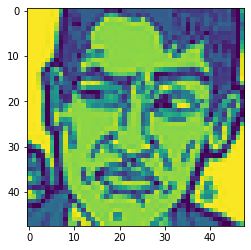

Emoção original:  Disgust
Emoção classificação:  Disgust


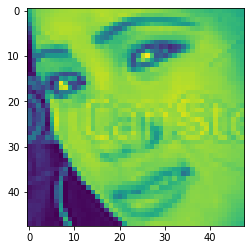

Emoção original:  Sad
Emoção classificação:  Angry


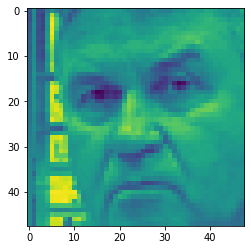

Emoção original:  Neutral
Emoção classificação:  Angry


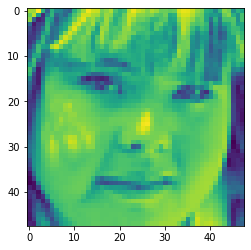

Emoção original:  Happy
Emoção classificação:  Happy


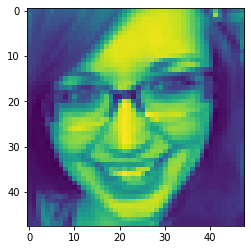

Emoção original:  Fear
Emoção classificação:  Fear


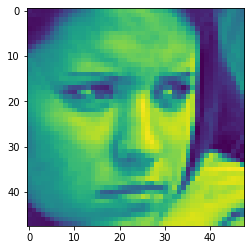

Emoção original:  Surprise
Emoção classificação:  Surprise


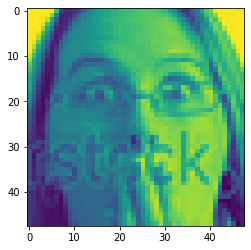

In [152]:
# Printing some predicted examples
for id in [28709, 28710, 28711, 28712, 28713, 35886, 28725]:
    plt.imshow(images[id])
    print('Emoção original: ', results.emotion[id])
    print('Emoção classificação: ', results.emotion_pred[id])
    plt.show()    